<a href="https://colab.research.google.com/github/Riky2014/Tesi/blob/main/1d_hemo_solver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [675]:
%%capture
!apt-get install software-properties-common
!add-apt-repository -y ppa:fenics-packages/fenics
!apt-get update -qq
!apt install fenics

In [678]:
from fenics import *
import numpy as np
import matplotlib.pyplot as plt

# Data, Mesh and Function spaces

In [742]:
# Data
T = 1
x_left = 0.
x_right = 1.0
alpha = 1

A_tilde = 4e-4
a_tilde = 4e-5
q_tilde = 0.0
K_tilde = 50e3

k_r = 2.416e-4
rho = 1.05

T = 1
L = 1

# Discretization parameter
dt = 2.5e-5
h = 1e-1
num_steps = T / dt
N = int((x_right - x_left) / h)

#  Create a mesh on the interval [0, 1].
mesh = IntervalMesh(N, x_left, x_right)
x = MeshCoordinates(mesh)

# Define the function space
P1 = FiniteElement('P', mesh.ufl_cell(), 1)
element = MixedElement([P1, P1])
V = FunctionSpace(mesh, element)

# Derivative function space
D1 = FiniteElement('DG', mesh.ufl_cell(), 0)
element_der = MixedElement([D1, D1])
V_der = FunctionSpace(mesh, element_der)

# Exact solution and forcing term

In [743]:
# Exact solution and forcing term

A_exact = Expression('A_tilde + a_tilde * sin(2 * pi / L * x[0]) * cos(2 * pi / T * t)', A_tilde = A_tilde, a_tilde = a_tilde, L = L, T = T, degree = 2, t = 0)

q_exact = Expression('q_tilde - (a_tilde * L / T) * cos(2 * pi / L * x[0]) * sin(2 * pi / T * t)', q_tilde = q_tilde, a_tilde = a_tilde, L = L, T = T, degree = 2, t = 0)

dU_dt = Expression(('- 2 * pi * a_tilde * sin(2 * pi * t) * sin(2 * pi * x[0])',

                    '- 2 * pi * a_tilde * L / T * cos(2 * pi * t) * cos(2 * pi * x[0])'),
                    a_tilde = a_tilde, L = L, T = T, degree = 1, t = 0)

S = Expression(('0.',

                'k_r * (q_tilde - (a_tilde * L / T) * cos(2 * pi / L * x[0]) * sin(2 * pi / T * t)) / (A_tilde + a_tilde * sin(2 * pi / L * x[0]) * cos(2 * pi / T * t))'),
                A_tilde = A_tilde, a_tilde = a_tilde, q_tilde = q_tilde, L = L, T = T, k_r = k_r, degree = 1, t = 0)

dF_dx = Expression(('2 * pi * a_tilde * L / T * sin(2 * pi * t) * sin(2 * pi * x[0])',

                    'pi * K_tilde * a_tilde / rho * pow(0.1 * sin(2 * pi * x[0]) * cos(2 * pi * t) + 1, 0.5) * cos(2 * pi * t) * cos(2 * pi * x[0]) \
                    - 2 * pi * pow(a_tilde, 3) * pow(L / (A_tilde * T), 2) * pow(sin(2 * pi * t), 2) * cos(2 * pi * t) * pow(cos(2 * pi * x[0]), 3) / pow(0.1 * sin(2 * pi * x[0]) * cos(2 * pi * t) + 1, 2) \
                    - 4 * pi * pow(a_tilde, 2) * pow(sin(2 * pi * t), 2) * sin(2 * pi * x[0]) * cos(2 * pi * x[0]) / (A_tilde + a_tilde * sin(2 * pi * x[0]) * cos(2 * pi * t))'),
                    a_tilde = a_tilde, A_tilde = A_tilde, K_tilde = K_tilde, L = L, T = T, rho = rho, degree = 1, t = 0)

dU_dt_dt = Expression(('- 4 * pi * pi * a_tilde * sin(2 * pi * x[0]) * cos(2 * pi * t)',

                       '4 * pi * pi * a_tilde * sin(2 * pi * t) * cos(2 * pi * x[0])'),
                       a_tilde = a_tilde, L = L, T = T, degree = 1, t = 0)

dS_dt = Expression(('0.',

                    '- 2 * pi * k_r * pow(a_tilde / A_tilde, 2) * pow(sin(2 * pi * t), 2) * sin(2 * pi * x[0]) * cos(2 * pi * x[0]) / (pow(0.1 * sin(2 * pi * x[0]) * cos(2 * pi * t) + 1, 2)) \
                    - 2 * pi * k_r * a_tilde * cos(2 * pi * t) * cos(2 * pi * x[0]) / (A_tilde + a_tilde * sin(2 * pi * x[0]) * cos(2 * pi * t))'),
                    A_tilde = A_tilde, a_tilde = a_tilde, q_tilde = q_tilde, L = L, T = T, k_r = k_r, degree = 1, t = 0)

dF_dx_dt = Expression(('4 * pi * pi * a_tilde * L / T * cos(2 * pi * t) * sin(2 * pi * x[0])',

                    '- 0.1 * pi * pi * K_tilde * a_tilde / rho * sin(2 * pi * t) * sin(2 * pi * x[0]) * cos(2 * pi * t) * cos(2 * pi * x[0]) / pow(0.1 * sin(2 * pi * x[0]) * cos(2 * pi * t) + 1, 0.5) \
                    - 2 * pi * pi * K_tilde * a_tilde / rho * pow(0.1 * sin(2 * pi * x[0]) * cos(2 * pi * t) + 1, 0.5) * sin(2 * pi * t) * cos(2 * pi * x[0]) \
                    - 8 * pi * pi * pow(a_tilde, 3) * pow(L / (A_tilde * T), 2) * pow(sin(2 * pi * t), 3) * pow(sin(2 * pi * x[0]), 2) * cos(2 * pi * x[0]) / pow(0.1 * sin(2 * pi * x[0]) * cos( 2 * pi * t) + 1, 2) \
                    + 4 * pi * pi * pow(a_tilde, 3) * pow(L / (A_tilde * T), 2) * pow(sin(2 * pi * t), 3) * pow(cos(2 * pi * x[0]), 3) / pow(0.1 * sin(2 * pi * x[0]) * cos( 2 * pi * t) + 1, 2) \
                    - 8 * pi * pi * pow(a_tilde, 3) * pow(L / (A_tilde * T), 2) * sin(2 * pi * t) * pow(cos(2 * pi * t), 2) * pow(cos(2 * pi * x[0]), 3) / pow(0.1 * sin(2 * pi * x[0]) * cos( 2 * pi * t) + 1, 2) \
                    - 0.8 * pi * pi * pow(a_tilde, 3) * pow(L / (A_tilde * T), 2) * pow(sin(2 * pi * t), 3) * sin(2 * pi * x[0]) * cos(2 * pi * t) * pow(cos(2 * pi * x[0]), 3) / pow(0.1 * sin(2 * pi * x[0]) * cos( 2 * pi * t) + 1, 3) \
                    - 16 * pi * pi * pow(a_tilde, 2) * sin(2 * pi * t) * sin(2 * pi * x[0]) * cos(2 * pi * t) * cos(2 * pi * x[0]) / (A_tilde + a_tilde * sin(2 * pi * x[0]) * cos(2 * pi * t))'),
                    a_tilde = a_tilde, A_tilde = A_tilde, K_tilde = K_tilde, L = L, T = T, rho = rho, degree = 1, t = 0)

f = dU_dt + S + dF_dx
f_n = project(f, V)

df_dt = dU_dt_dt + dS_dt + dF_dx_dt
df_dt_n = project(df_dt, V)

# Functions

In [744]:
def H(A, q):
  return as_tensor([[0, 1], [1190476.19048 * A ** 0.5 - (q / A) ** 2, 2 * q / A]])

def F(A, q):
  return as_vector([q, 793650.79365 * A ** 1.5 - 6.34921 + q ** 2 / A])

def B(A, q):
  return as_vector([0, k_r * q / A])

def S(A, q):
  return as_vector([0, k_r * q / A])

def dS_dU(A, q):
  return as_tensor([[0, 0], [- k_r * q / A ** 2, k_r / A]])

In [745]:
def U(A, q):
  return np.array([A, q])

def H_vec(A, q):
  return np.array([[0, 1], [1190476.19048 * A ** 0.5 - (q / A) ** 2, 2 * q / A]])

def B_vec(A, q):
  return np.array([0, k_r * q / A])

def S_vec(A, q):
  return np.array([0, k_r * q / A])

def c_alpha(A, q, alpha = 1):
  return (1190476.19048 * A ** 0.5 + (q / A) ** 2 * alpha * (alpha - 1)) ** 0.5

def l1(A, q, alpha = 1):
  return np.array([c_alpha(A, q, alpha) - alpha * q / A, 1.])

def l2(A, q, alpha = 1):
  return np.array([- c_alpha(A, q, alpha) - alpha * q / A, 1.])

def CC(A, q, u_der, x):
  du_dz = project(u_der, V_der)(x)
  return U(A, q) - dt * H_vec(A, q) @ du_dz - dt * B_vec(A, q) + dt * f([x, x, x])

In [746]:
def inlet_bc(A, q, u_der):
  q_inlet = (np.dot(l2(A(x_left), q(x_left)), CC(A(x_left), q(x_left), u_der, x_left)) - l2(A(x_left), q(x_left))[0] * U(A(x_left), q(x_left))[0] ) / l2(A(x_left), q(x_left))[1]

  return q_inlet

def outlet_bc(A, q, u_der):
  matrix = np.array([[1, -1], [c_alpha(A(x_right), q(x_right), alpha) + alpha * q(x_right) / A(x_right), c_alpha(A(x_right), q(x_right), alpha) - alpha * q(x_right) / A(x_right)]])
  array = np.array([np.dot(l1(A(x_right), q(x_right)), CC(A(x_right), q(x_right), u_der, x_right)), np.dot(l2(A(x_right), q(x_right)), U(A(x_right), q(x_right)) - dt * S_vec(A(x_right), q(x_right)))])

  A_out, q_out = matrix @ array / (2 * c_alpha(A(x_right), q(x_right)))

  return A_out, q_out

In [747]:
def update_time_step(t, dt):
  t += dt
  q_exact.t = t
  A_exact.t = t
  dU_dt.t = t
  S.t = t
  dF_dx.t = t
  dU_dt_dt.t = t
  dS_dt.t = t
  dF_dx_dt.t = t

  return t

# Initial guess and boundary conditions

In [748]:
# Define initial guess
A0 = 4e-4
q0 = 0
uh_old = interpolate(Expression(('A_tilde + a_tilde * sin(2 * pi / L * x[0])', 'q0'), degree = 2, A_tilde = A_tilde, a_tilde = a_tilde, L = L, q0 = q0), V)
Ah_old, qh_old = uh_old.split()

In [749]:
# Boundary condition
inlet = 'near(x[0], 0)'
outlet = 'near(x[0], 1)'
A_inlet = A0
q_inlet = inlet_bc(Ah_old, qh_old, uh_old.dx(0))
A_outlet, q_outlet = outlet_bc(Ah_old, qh_old, uh_old.dx(0))
#print(f'A inlet = {A_inlet}, q inlet = {q_inlet}')
#print(f'A outlet = {A_outlet}, q outlet = {q_outlet}')

# Dirichlet bc
bc_A_inlet = DirichletBC(V.sub(0), A_inlet, inlet)
# I should impose compatibility condition
bc_q_inlet = DirichletBC(V.sub(1), q_inlet, inlet)

# Non reflecting bc
bc_A_outlet = DirichletBC(V.sub(0), A_outlet, outlet)
# I should impose compatibility condition
bc_q_outlet = DirichletBC(V.sub(1), q_outlet, outlet)

bc = [bc_A_inlet, bc_q_inlet, bc_A_outlet, bc_q_outlet]

A inlet = 0.0004, q inlet = 9.644497391742002e-06
A outlet = 0.00040003125174338115, q outlet = 4.822248695872079e-06


# Definition of the variational problem

In [750]:
# Define trial functions and test functions
A, q = TrialFunctions(V)
v, z = TestFunctions(V)

# Define the variational problem
def LinearProblem(A_old, q_old):
  a = inner(A, v) * dx + inner(q, z) * dx

  L = (
        A_old * v * dx
      + q_old * z * dx
      + dt * ((F(A_old, q_old) - dt / 2 * dot(H(A_old, q_old), S(A_old, q_old))))[0] * v.dx(0) * dx
      + dt * ((F(A_old, q_old) - dt / 2 * dot(H(A_old, q_old), S(A_old, q_old))))[1] * z.dx(0) * dx
      + dt ** 2 / 2 * (dot(dS_dU(A_old, q_old), F(A_old, q_old).dx(0)))[0] * v * dx
      + dt ** 2 / 2 * (dot(dS_dU(A_old, q_old), F(A_old, q_old).dx(0)))[1] * z * dx
      - dt ** 2 / 2 * (dot(H(A_old, q_old), F(A_old, q_old).dx(0)))[0] * v.dx(0) * dx
      - dt ** 2 / 2 * (dot(H(A_old, q_old), F(A_old, q_old).dx(0)))[1] * z.dx(0) * dx
      - dt * (S(A_old, q_old) - dt / 2 * dot(dS_dU(A_old, q_old), S(A_old, q_old)))[0] * v * dx
      - dt * (S(A_old, q_old) - dt / 2 * dot(dS_dU(A_old, q_old), S(A_old, q_old)))[1] * z * dx
      + dt * f[0] * v * dx
      + dt * f[1] * z * dx
      + dt ** 2 / 2 * (dot(H(A_old, q_old), f_n))[0] * v.dx(0) * dx
      + dt ** 2 / 2 * (dot(H(A_old, q_old), f_n))[1] * z.dx(0) * dx
      + dt ** 2 / 2 * (- dot(dS_dU(A_old, q_old), f_n) + df_dt_n)[0] * v * dx
      + dt ** 2 / 2 * (- dot(dS_dU(A_old, q_old), f_n) + df_dt_n)[1] * z * dx
  )

  return a, L

# Solution

In [ ]:
# Time stepping
uh = Function(V)
t = 0
i = 0

global_error_A = 0
global_error_q = 0

for n in range(round(num_steps)):

  i +=1

  # Update time step
  t = update_time_step(t, dt)

  # Solve the problem
  a, L = LinearProblem(Ah_old, qh_old)
  solve(a == L, uh, bc)
  Ah, qh = uh.split(deepcopy = True)

  A_e = interpolate(A_exact, V.sub(0).collapse())
  q_e = interpolate(q_exact, V.sub(1).collapse())
  error = np.array([errornorm(Ah, A_e, 'L2'), errornorm(qh, q_e, 'L2')])

  if error[0] > global_error_A:
    global_error_A = error[0]

  if error[1] > global_error_q:
    global_error_q = error[1]

  # Compute errors
  if (i % 100 == 0):
    print(f'Interation {i} / {round(num_steps)}')
    print(f't = %.4f: error = {error}' % (t))
    print(f'Global error A = {global_error_A}, Global error q = {global_error_q}')
    print()

  # Update previous solution
  Ah_old.assign(Ah)
  qh_old.assign(qh)

  q_inlet = inlet_bc(Ah_old, qh_old, uh.dx(0))
  A_outlet, q_outlet = outlet_bc(Ah_old, qh_old, uh.dx(0))

In [777]:
print(f'h = {h}, dt = {dt} : Global error A = {global_error_A}, Global error q = {global_error_q}')

h = 0.1, dt = 2.5e-05 : Global error A = 6.335662421082552e-08, Global error q = 0.00019046053983005933


# Time convergence

In [ ]:
# Time stepping
dt_vec = 2e-4 * np.array([1, 1/2, 1/4, 1/8])
error_A = []
error_q = []

for j in range(len(dt_vec)):
  dt = dt_vec[j]
  print(f'dt = {dt}')
  print()

  uh = Function(V)
  t = 0
  i = 0

  global_error_A = 0
  global_error_q = 0

  num_steps = T / dt

  for n in range(round(num_steps)):

    i +=1

    # Update time step
    t = update_time_step(t, dt)

    # Solve the problem
    a, L = LinearProblem(Ah_old, qh_old)
    solve(a == L, uh, bc)
    Ah, qh = uh.split(deepcopy = True)

    A_e = interpolate(A_exact, V.sub(0).collapse())
    q_e = interpolate(q_exact, V.sub(1).collapse())
    error = np.array([errornorm(Ah, A_e, 'L2'), errornorm(qh, q_e, 'L2')])

    if error[0] > global_error_A:
      global_error_A = error[0]

    if error[1] > global_error_q:
      global_error_q = error[1]

    # Compute errors
    if (i % 1000 == 0):
      print(f'Interation {i} / {round(num_steps)}')
      print(f't = %.4f: error = {error}' % (t))
      print(f'Global error A = {global_error_A}, Global error q = {global_error_q}')
      print()

    # Update previous solution
    Ah_old.assign(Ah)
    qh_old.assign(qh)

    q_inlet = inlet_bc(Ah_old, qh_old, uh.dx(0))
    A_outlet, q_outlet = outlet_bc(Ah_old, qh_old, uh.dx(0))

  error_A.append(global_error_A)
  error_q.append(global_error_q)

Text(0, 0.5, 'Error')

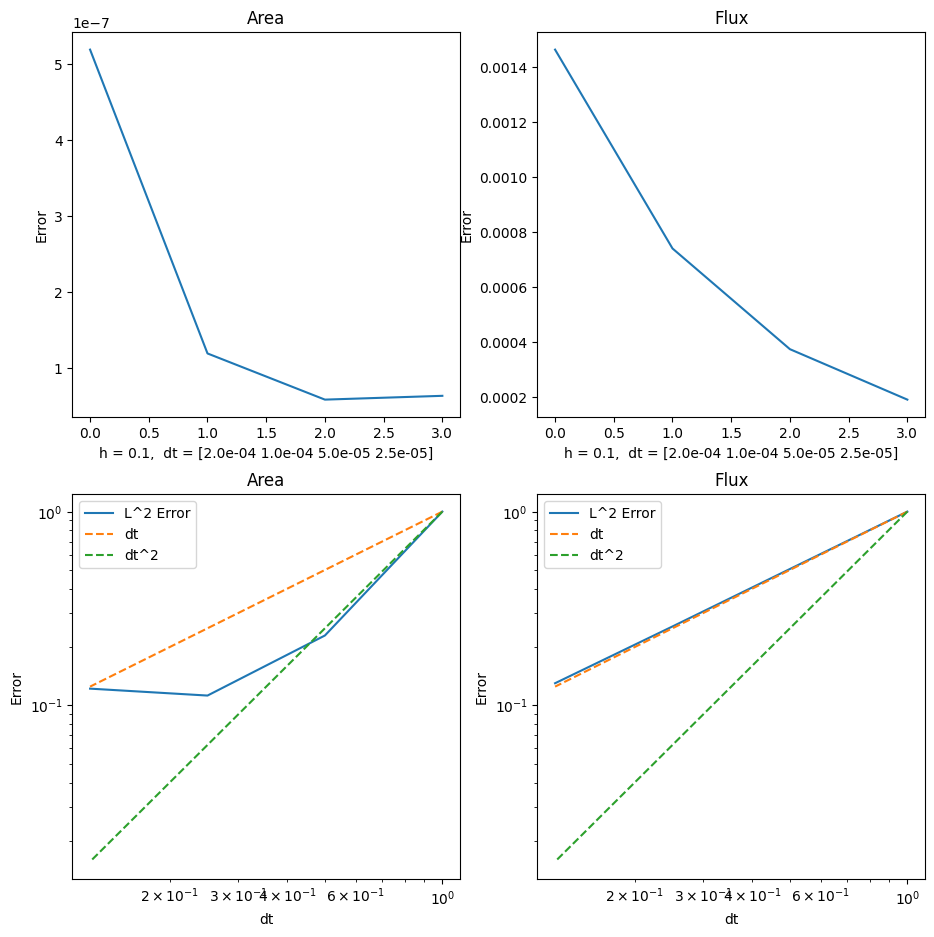

In [798]:
fig, ax = plt.subplots(2, 2, figsize=(11, 11))
ax = ax.flatten()

# Plot for Area
ax[0].plot(error_A)
ax[0].set_title('Area')
ax[0].set_xlabel(f'h = {h},  dt = {dt_vec}')
ax[0].set_ylabel('Error')

ax[2].loglog(dt_vec / dt_vec[0], error_A / error_A[0], label = 'L^2 Error')
ax[2].loglog(dt_vec / dt_vec[0], dt_vec / dt_vec[0], linestyle = '--', label = 'dt')
ax[2].loglog(dt_vec / dt_vec[0], (dt_vec / dt_vec[0])**2, linestyle = '--', label ='dt^2')
ax[2].set_xlabel('dt')
ax[2].set_ylabel('Error')
ax[2].set_title('Area')
ax[2].legend()

# Plot for Flux
ax[1].plot(error_q)
ax[1].set_title('Flux')
ax[1].set_xlabel(f'h = {h},  dt = {dt_vec}')
ax[1].set_ylabel('Error')

ax[3].loglog(dt_vec / dt_vec[0], error_q / error_q[0], label = 'L^2 Error')
ax[3].loglog(dt_vec / dt_vec[0], dt_vec / dt_vec[0], linestyle = '--', label = 'dt')
ax[3].loglog(dt_vec / dt_vec[0], (dt_vec / dt_vec[0])**2, linestyle = '--', label = 'dt^2')
ax[3].set_xlabel('dt')
ax[3].set_ylabel('Error')
ax[3].set_title('Flux')
ax[3].legend()